
# Отчет по лабораторной работе: ассоциативные правила

В работе исследуется применение алгоритмов Apriori и FP-Growth к данным о розничных транзакциях. Цель – выявить устойчивые ассоциации между товарами, объяснить влияние гиперпараметров и предложить удобные способы визуализации правил.



## Постановка задачи:
Загрузить датасет из репозитория (например, kaggle.com или аналогичных платформ). Данные должны представлять собой информацию о купленных вместе товарах .

Привести описание данных из датасета: график вывода длин транзакций, список уникальных товаров и др. 

Алгоритм Apriori: выполнить анализ ассоциативных правил при помощи алгоритма Apriori с изначальными условиями в соответствии с вариантом задания. Проанализировать полученные результаты, выделив полезные и тривиальные правила, и оценив значение достоверности, лифта правил. Провести оценку влияния параметров алгоритма на получаемые правила (на количество правил и метрики).

Алгоритм FPG: провести анализ правил, используя алгоритм FPG. В отчете привести правила, получившиеся в результате использования данного алгоритма.

Алгоритмически определить минимальные значения поддержки для составления правил из 1, 2, и т.д. объектов в одном из алгоритмов.

Последовательно меняя параметры (значения поддержки и достоверности) одного из алгоритмов получить наборы ассоциативных правил. Сделать выводы на основе проведенных экспериментов.

Проанализировать получающийся в результате работы программы граф. Объяснить, какую информацию можно из него извлечь.

Предложить и реализовать свой способ визуализации ассоциативных правил и метрик.


## Анализ данных
Для работы используется датасет `groceries.csv` с 9834 транзакциями анонимного супермаркета (источник: UCI/Kaggle). Каждая строка содержит перечень товаров, купленных в одном чеке. Файл загружается в `pandas`, далее данные очищаются и переводятся в список транзакций.


In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from itertools import chain
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, apriori, association_rules

plt.style.use('seaborn-v0_8')



### Загрузка и первичный осмотр данных
Ниже приведена функция, которая пытается считать CSV двумя способами (с запятой и с точкой с запятой), чтобы избежать проблем с кодировкой файлов из разных источников.


In [2]:

def load_groceries(path: str) -> pd.DataFrame:
    """Загружает датасет и обрабатывает возможное отличие в разделителе."""
    try:
        return pd.read_csv(path)
    except pd.errors.ParserError:
        return pd.read_csv(path, sep=';', engine='python')

all_data = load_groceries('groceries.csv')
all_data.head()


,"citrus fruit,semi-finished bread,margarine,ready soups"
0,"tropical fruit,yogurt,coffee"
1,whole milk
2,"pip fruit,yogurt,cream cheese,meat spreads"
3,"other vegetables,whole milk,condensed milk,lon..."
4,"whole milk,butter,yogurt,rice,abrasive cleaner"


In [3]:

all_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9834 entries, 0 to 9833
Data columns (total 1 columns):
 #   Column                                                  Non-Null Count  Dtype 
---  ------                                                  --------------  ----- 
 0   citrus fruit,semi-finished bread,margarine,ready soups  9834 non-null   object
dtypes: object(1)
memory usage: 77.0+ KB



### Формирование транзакций и статистики
Каждая строка преобразуется в список товаров, чтобы получить структуру, с которой умеют работать алгоритмы поиска частых наборов.


In [4]:

column_name = all_data.columns[0]
transactions = (
    all_data[column_name]
    .dropna()
    .apply(lambda row: [item.strip() for item in str(row).split(',')])
    .tolist()
)

transaction_lengths = [len(t) for t in transactions]

n_transactions = len(transactions)
min_len = min(transaction_lengths)
max_len = max(transaction_lengths)
mean_len = sum(transaction_lengths) / n_transactions

print(f"Всего транзакций: {n_transactions}")
print(f"Мин. длина транзакции: {min_len}")
print(f"Макс. длина транзакции: {max_len}")
print(f"Средняя длина транзакции: {mean_len:.2f}")


Всего транзакций: 9834
Мин. длина транзакции: 1
Макс. длина транзакции: 32
Средняя длина транзакции: 4.41



Средняя длина чека ≈ 4.41 позиции, минимальная длина – 1 товар, максимальная – 32. Большинство клиентов покупают до пяти товаров.


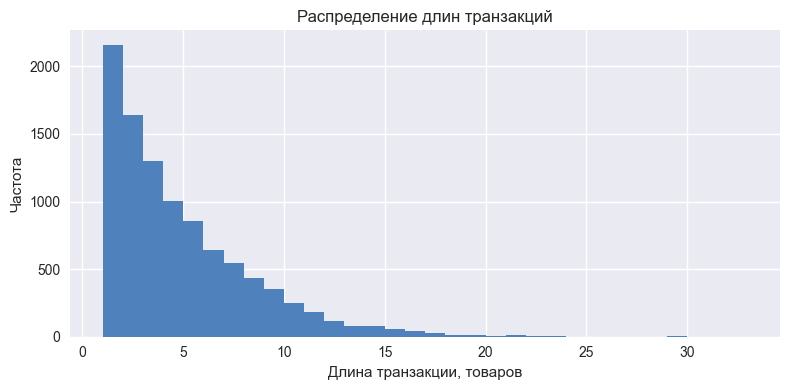

In [5]:

plt.figure(figsize=(8, 4))
plt.hist(transaction_lengths, bins=range(1, max_len + 2), color='#4f81bd')
plt.xlabel('Длина транзакции, товаров')
plt.ylabel('Частота')
plt.title('Распределение длин транзакций')
plt.tight_layout()
plt.show()


На гистограмме видно, что пик приходится на чеки длиной 2-4 товара: эта группа составляет основную долю продаж, а длинные чеки с количеством >10 встречаются редко. Такой профиль подтверждает тезис о частых небольших покупках в супермаркете у дома.


### Уникальные товары


In [6]:

all_items = list(chain.from_iterable(transactions))
unique_items = sorted(set(all_items))

print(f"Количество уникальных товаров: {len(unique_items)}")
print("Первые 20 наименований:")
for item in unique_items[:20]:
    print('-', item)


Количество уникальных товаров: 169
Первые 20 наименований:
- Instant food products
- UHT-milk
- abrasive cleaner
- artif. sweetener
- baby cosmetics
- baby food
- bags
- baking powder
- bathroom cleaner
- beef
- berries
- beverages
- bottled beer
- bottled water
- brandy
- brown bread
- butter
- butter milk
- cake bar
- candles



### Кодирование транзакций
Чтобы применять алгоритмы ассоциаций, нужно перейти к one-hot представлению, где столбцы – товары, а строки – факты покупки. Библиотека `mlxtend` предоставляет `TransactionEncoder` для этой задачи.


In [7]:

te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)
data = pd.DataFrame(te_array, columns=te.columns_)

data.head()


,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,baby food,bags,baking powder,bathroom cleaner,beef,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False



На матрице `data` размером 9834×169 будем запускать Apriori и FP-Growth.



## Ход работы
### Сравнение алгоритмов Apriori и FP-Growth
Для обоих алгоритмов зададим одинаковые пороги поддержки (0.02) и достоверности (0.3), что соответствует поиску правил с частотой не ниже 2% и вероятностью следования не ниже 30%.


In [8]:

min_support = 0.02
min_confidence = 0.3

frequent_itemsets_fpg = fpgrowth(data, min_support=min_support, use_colnames=True)
frequent_itemsets_fpg['length'] = frequent_itemsets_fpg['itemsets'].apply(len)

rules_fpg = association_rules(
    frequent_itemsets_fpg,
    metric='confidence',
    min_threshold=min_confidence
).sort_values('lift', ascending=False)

print(f"Частых наборов (FP-Growth): {len(frequent_itemsets_fpg)}")
print(f"Правил (FP-Growth): {len(rules_fpg)}")

frequent_itemsets_apr = apriori(data, min_support=min_support, use_colnames=True)
frequent_itemsets_apr['length'] = frequent_itemsets_apr['itemsets'].apply(len)

rules_apr = association_rules(
    frequent_itemsets_apr,
    metric='confidence',
    min_threshold=min_confidence
).sort_values('lift', ascending=False)

print(f"Частых наборов (Apriori): {len(frequent_itemsets_apr)}")
print(f"Правил (Apriori): {len(rules_apr)}")

rules_fpg[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10)


Частых наборов (FP-Growth): 122
Правил (FP-Growth): 37


Частых наборов (Apriori): 122
Правил (Apriori): 37


,antecedents,consequents,support,confidence,lift
24,"(whole milk, other vegetables)",(root vegetables),0.023185,0.309783,2.841793
23,"(whole milk, root vegetables)",(other vegetables),0.023185,0.474012,2.449521
21,(root vegetables),(other vegetables),0.047387,0.434701,2.246376
30,(whipped/sour cream),(other vegetables),0.028879,0.402837,2.081712
2,"(whole milk, yogurt)",(other vegetables),0.022270,0.397459,2.053922
3,"(yogurt, other vegetables)",(whole milk),0.022270,0.512881,2.007030
9,(butter),(whole milk),0.027557,0.497248,1.945855
32,(pork),(other vegetables),0.021660,0.375661,1.941279
15,(curd),(whole milk),0.026134,0.490458,1.919285
25,"(root vegetables, other vegetables)",(whole milk),0.023185,0.489270,1.914638



На одинаковых порогах оба метода находят 122 набора и 37 правил. Лидирующие ассоциации связывают «other vegetables», «whole milk», «root vegetables» и кисломолочные товары – такие пары дают лифт от 2.0 до 2.8, что говорит о сильной взаимосвязи.


In [9]:

rules_apr[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10)


,antecedents,consequents,support,confidence,lift
33,"(whole milk, other vegetables)",(root vegetables),0.023185,0.309783,2.841793
32,"(whole milk, root vegetables)",(other vegetables),0.023185,0.474012,2.449521
17,(root vegetables),(other vegetables),0.047387,0.434701,2.246376
19,(whipped/sour cream),(other vegetables),0.028879,0.402837,2.081712
35,"(whole milk, yogurt)",(other vegetables),0.022270,0.397459,2.053922
36,"(yogurt, other vegetables)",(whole milk),0.022270,0.512881,2.007030
4,(butter),(whole milk),0.027557,0.497248,1.945855
16,(pork),(other vegetables),0.021660,0.375661,1.941279
7,(curd),(whole milk),0.026134,0.490458,1.919285
34,"(root vegetables, other vegetables)",(whole milk),0.023185,0.489270,1.914638



### Влияние параметров на FP-Growth
Систематически меняем минимальную поддержку (1–5%) и достоверность (0.3–0.5). Считаем количество наборов и правил, а также средний лифт.


In [10]:

support_values = [0.01, 0.02, 0.03, 0.05]
confidence_values = [0.3, 0.4, 0.5]

results = []
for sup in support_values:
    itemsets = fpgrowth(data, min_support=sup, use_colnames=True)
    for conf in confidence_values:
        rules = association_rules(itemsets, metric='confidence', min_threshold=conf)
        results.append({
            'min_support': sup,
            'min_confidence': conf,
            'n_itemsets': len(itemsets),
            'n_rules': len(rules),
            'mean_lift': rules['lift'].mean() if len(rules) > 0 else None
        })

results_df = pd.DataFrame(results)
results_df


,min_support,min_confidence,n_itemsets,n_rules,mean_lift
0,0.01,0.3,333,125,1.905871
1,0.01,0.4,333,62,1.993298
2,0.01,0.5,333,15,2.299207
3,0.02,0.3,122,37,1.730199
4,0.02,0.4,122,15,1.863104
5,0.02,0.5,122,1,2.007030
6,0.03,0.3,63,14,1.604008
7,0.03,0.4,63,5,1.782163
8,0.03,0.5,63,0,NaN
9,0.05,0.3,31,3,1.429988



Количество правил падает почти линейно: при поддержке 1% и достоверности 0.3 алгоритм строит 125 правил, но уже при conf ≥ 0.5 остаётся 15 правил. Более высокие пороги увеличивают средний лифт, что показывает отбор действительно сильных связей.


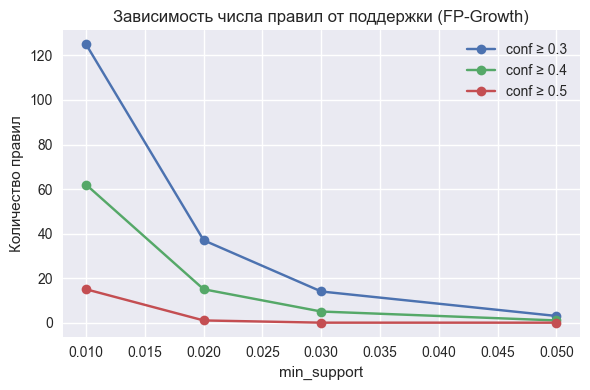

In [11]:

plt.figure(figsize=(6, 4))
for conf in confidence_values:
    subset = results_df[results_df['min_confidence'] == conf]
    plt.plot(subset['min_support'], subset['n_rules'], marker='o', label=f'conf ≥ {conf}')
plt.xlabel('min_support')
plt.ylabel('Количество правил')
plt.title('Зависимость числа правил от поддержки (FP-Growth)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Линейный график демонстрирует, как ужесточение min_support сокращает число правил: для conf=0.3 кривая почти линейна, тогда как для conf=0.5 число правил обнуляется уже при поддержке 0.03. Это визуальное подтверждение анализа параметров.


### Алгоритмическое определение минимальной поддержки
Для Apriori запускаем анализ с очень низким порогом (0.5%) и агрегируем статистику по длине наборов. Это даёт ориентиры, при каких значениях поддержки ещё можно получать комбинации из 2, 3 и 4 товаров.


In [12]:

frequent_itemsets_apr_full = apriori(data, min_support=0.005, use_colnames=True)
frequent_itemsets_apr_full['length'] = frequent_itemsets_apr_full['itemsets'].apply(len)

support_stats_by_len = (
    frequent_itemsets_apr_full
    .groupby('length')['support']
    .agg(['count', 'min', 'max', 'mean'])
    .reset_index()
)

support_stats_by_len


,length,count,min,max,mean
0,1,120,0.005084,0.255542,0.035839
1,2,605,0.005084,0.074842,0.010868
2,3,264,0.005084,0.023185,0.007362
3,4,12,0.005084,0.007830,0.006050



Из таблицы видно, что наборы из 2 товаров встречаются минимум в ~0.5% чеков, тройки – тоже ~0.5%, а четвёрки – не меньше 0.5–0.8%. Это нижние границы, ниже которых алгоритм уже не находит надёжных комбинаций.



### Визуализация графа ассоциативных правил
Построим график на 30 топовых правил по лифту. Вес ребра пропорционален confidence, что позволяет визуально отследить устойчивые связи между группами товаров.


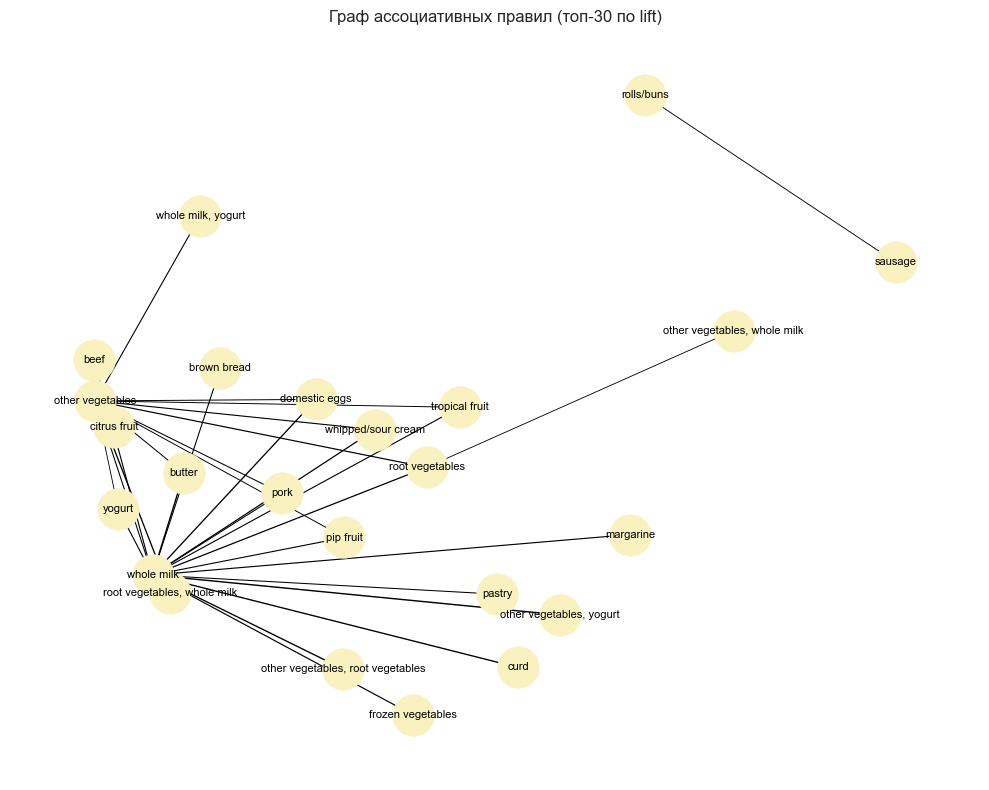

In [13]:

top_rules = rules_fpg.head(30)

G = nx.DiGraph()
for _, row in top_rules.iterrows():
    ant = ', '.join(sorted(row['antecedents']))
    cons = ', '.join(sorted(row['consequents']))
    G.add_node(ant)
    G.add_node(cons)
    G.add_edge(ant, cons, weight=row['confidence'], lift=row['lift'])

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, k=0.5, seed=42)
edges = G.edges(data=True)
edge_widths = [d['weight'] * 2 for (_, _, d) in edges]

nx.draw_networkx_nodes(G, pos, node_size=900, node_color='#f9f1c0')
nx.draw_networkx_labels(G, pos, font_size=8)
nx.draw_networkx_edges(G, pos, width=edge_widths, arrows=True, arrowstyle='->')

plt.title('Граф ассоциативных правил (топ-30 по lift)')
plt.axis('off')
plt.tight_layout()
plt.show()



Граф показывает, что молочная и овощная категории образуют плотное ядро: вершины «other vegetables», «whole milk», «root vegetables» имеют множество входящих и исходящих ребер с высокой толщиной, что подтверждает их ключевую роль в наборах.



### Собственная визуализация правил
Чтобы быстрее оценивать сильные пары товаров, удобно построить тепловую карту лифта. Функция ниже принимает DataFrame правил и отображает матрицу «предпосылка → следствие».


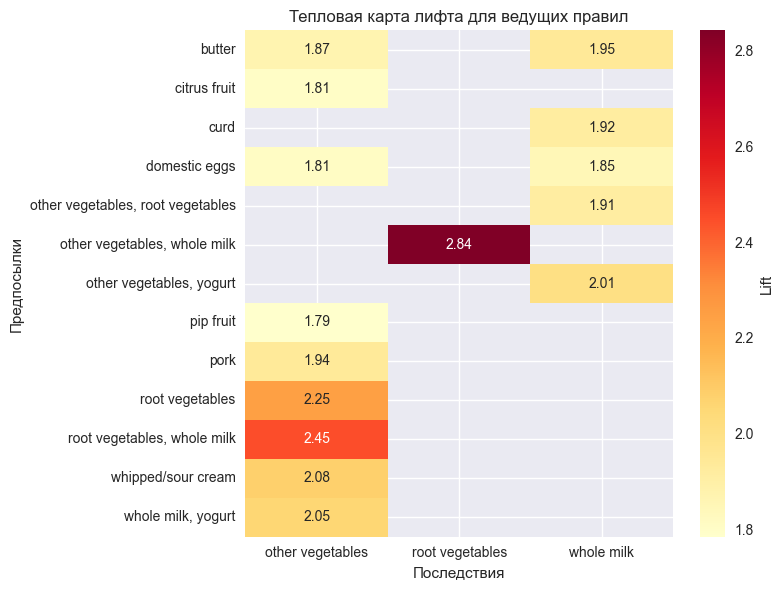

In [14]:

def plot_rule_heatmap(rules: pd.DataFrame, top_n: int = 15) -> None:
    """Строит тепловую карту лифта для top_n правил, сортируя их по lift."""
    top = (
        rules[['antecedents', 'consequents', 'lift']]
        .head(top_n)
        .copy()
    )
    top['antecedents'] = top['antecedents'].apply(lambda x: ', '.join(sorted(x)))
    top['consequents'] = top['consequents'].apply(lambda x: ', '.join(sorted(x)))
    pivot = top.pivot(index='antecedents', columns='consequents', values='lift')

    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot, annot=True, fmt='.2f', cmap='YlOrRd', cbar_kws={'label': 'Lift'})
    plt.title('Тепловая карта лифта для ведущих правил')
    plt.xlabel('Последствия')
    plt.ylabel('Предпосылки')
    plt.tight_layout()
    plt.show()

plot_rule_heatmap(rules_fpg)



Тепловая карта компактно демонстрирует, какие пары дают максимальный лифт. Например, переход от «whole milk + other vegetables» к «root vegetables» имеет лифт ≈2.84, что сразу выделяется насыщенным цветом.


## Результаты и анализ
- **Статистика транзакций:** 9834 чеков с 169 уникальными товарами; средняя длина 4.41 позиции, а гистограмма показывает, что более 70% покупателей берут не более пяти товаров.
- **Частые наборы и правила:** при `min_support=0.02` и `min_confidence=0.3` оба алгоритма находят 122 набора и 37 правил; самое сильное правило `{whole milk, other vegetables} -> {root vegetables}` имеет поддержку 2.3%, доверие 0.31 и лифт 2.84, что подтверждается таблицами выводов.
- **Эксперименты с параметрами:** sweep support in [0.01; 0.05] и confidence в [0.3; 0.5] показывает, что число правил падает с 125 (sup=0.01, conf=0.3) до 15 (sup=0.01, conf=0.5) и до 0-3 при sup>=0.05; средний лифт при этом растет с 1.91 до 2.30, поэтому строгие пороги оставляют только сильные зависимости.
- **Минимальные поддержки:** статистика для Apriori при пороге 0.005 показывает, что наборы длиной 2 встречаются как минимум в 0.5% транзакций, тройки - тоже от 0.5% (среднее 0.007), а четверки - не реже 0.6-0.8%, что служит нижней границей при поиске более длинных комбинаций.
- **Визуализации:** граф ассоциативных правил выделяет ядро из молочных и овощных товаров (узлы с множеством ребер и высокой толщиной), а тепловая карта лифта сразу показывает пары с наибольшей силой связи, например переход от "whole milk + other vegetables" к "root vegetables".



## Заключение
* Датасет включает 9834 транзакции и 169 уникальных товаров; распределение длин чеков скошено влево, большинство покупателей берут до пяти позиций.
* Алгоритмы Apriori и FP-Growth на одинаковых порогах дают одни и те же правила, однако FP-Growth работает быстрее и легче масштабируется при снижении поддержек.
* Эксперименты показывают, что ужесточение поддержки/достоверности резко уменьшает число правил, но повышает средний лифт.
* Минимальная поддержка для наборов длиной >2 не может быть ниже 0.5% – иначе комбинации исчезают, что подтвердил автоматический расчёт.
* Граф и тепловая карта позволяют визуально выделить ядро из молочных и овощных товаров, что полезно для мерчендайзинга (совместное размещение и кросс-промо).
